<a href="https://colab.research.google.com/github/deletella01/LLM_captone_project/blob/main/capstone__timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#/content/drive/MyDrive/Hamoye/NUTRITION2001_2022.csv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random
from prophet import Prophet
import logging
logging.getLogger("cmdstanpy").disabled = True

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Hamoye/NUTRITION2001_2022.csv')

In [ ]:
data.shape

(2398606, 30)

In [ ]:
# Rename columns
chunk = data.copy()

chunk.rename(columns={'REF_AREA:Geographic area':'Country',
                      'TIME_PERIOD:Time period':'Year',
                      'INDICATOR:Indicator':'Indicator',
                      'RESIDENCE:Residence':'Residence',
                      'WEALTH_QUINTILE:Wealth Quintile':'Poverty_Rating',
                      'MATERNAL_EDU_LVL:Mother\'s Education Level':'Maternal_Education',
                      'OBS_VALUE:Observation Value':'Observation_value'}, inplace=True)

chunk['Country'] = chunk['Country'].apply(lambda x:x[x.index(':')+1:])
chunk['Indicator'] = chunk['Indicator'].apply(lambda x:x[x.index(':')+1:])
chunk['Residence'] = chunk['Residence'].apply(lambda x:x[x.index(':')+1:])
chunk['Poverty_Rating'] = chunk['Poverty_Rating'].apply(lambda x:x[x.index(':')+1:])
chunk['Maternal_Education'] = chunk['Maternal_Education'].apply(lambda x:x[x.index(':')+1:])
chunk = chunk[~chunk['Year'].str.contains('-', na=False)]

df_list = ['Country','Year','Residence','Indicator','Poverty_Rating','Maternal_Education','Observation_value']

df1 = chunk[df_list]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2177962 entries, 0 to 2398605
Data columns (total 7 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Country             object 
 1   Year                object 
 2   Residence           object 
 3   Indicator           object 
 4   Poverty_Rating      object 
 5   Maternal_Education  object 
 6   Observation_value   float64
dtypes: float64(1), object(6)
memory usage: 132.9+ MB


In [ ]:
df = df1.copy()
df['Residence'] = df['Residence'].str.strip()
df.loc[df['Residence'] == 'Total', 'Residence'] = 'Suburban'
df['Residence'].unique()

array(['Suburban', 'Rural', 'Urban'], dtype=object)

In [ ]:
df['Maternal_Education'] = df['Maternal_Education'].str.strip()
ed_level = {'None and Primary':'Primary education',
            'Total':'Primary education',
            'Secondary and Higher': 'Secondary education',
            'Never attended an education programme / No schooling':'No education',
            'Secondary education (lower and upper secondary education)':'Secondary education'}
df['Maternal_Education'] = df['Maternal_Education'].replace(ed_level)
df['Maternal_Education'].unique()

array(['Primary education', 'Secondary education', 'Tertiary education',
       'No education'], dtype=object)

In [ ]:
df['Poverty_Rating'].unique()

array([' Total', ' Lowest', ' Second', ' Middle', ' Fourth', ' Highest',
       ' Bottom 20%', ' Bottom 40%', ' Bottom 60%', ' Bottom 80%',
       ' Richest 20%', ' Richest 40%', ' Richest 60%', ' Richest 80%'],
      dtype=object)

In [ ]:
df['Poverty_Rating'] =df['Poverty_Rating'].str.strip()
poverty_level = {'Total':'Middle class','Lowest':'Poor','Second':'Poor',
                 'Middle':'Middle class','Fourth':'Middle class','Highest':'Rich',
                 'Bottom 20%':'Poor','Bottom 40%':'Poor','Bottom 60%':'Middle class',
                 'Bottom 80%':'Middle class','Richest 20%':'Rich','Richest 40%':'Rich',
                 'Richest 60%':'Rich','Richest 80%':'Rich'}

df['Poverty_Rating'] = df['Poverty_Rating'].replace(poverty_level)
df['Poverty_Rating'].unique()

array(['Middle class', 'Poor', 'Rich'], dtype=object)

In [ ]:
africa_list = ['Algeria', 'Angola', 'Burundi', 'Benin', 'Burkina Faso', 'Botswana',
               'Central African Republic', "Côte d'Ivoire", 'Cameroon','Chad', 'Democratic Republic of the Congo',
               'Congo',  'Comoros', 'Cabo Verde', 'Djibouti', 'Egypt', 'Eritrea', 'Eswatini', 'Equatorial Guinea',
               'Ethiopia', 'Gabon', 'Ghana', 'Guinea', 'Gambia', 'Guinea-Bissau',  'Kenya', 'Liberia',
               'Lesotho', 'Libya', 'Morocco','Madagascar', 'Mauritius', 'Mali',' Mozambique', 'Mauritania', 'Malawi', 'Namibia',
               'Niger', 'Nigeria',  'Rwanda', 'Senegal', 'Sierra Leone', 'Somalia', 'South Sudan',
               'Sao Tome and Principe', 'South Africa', 'Seychelles', 'Sudan', 'Togo',
               'Tunisia', 'United Republic of Tanzania', 'Uganda', 'Zambia', 'Zimbabwe',]

len(africa_list)

54

In [ ]:
df['Country'] = df['Country'].str.strip()

df_afr = df[df['Country'].isin(africa_list)]
df_afr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972351 entries, 619 to 2398605
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Country             972351 non-null  object 
 1   Year                972351 non-null  object 
 2   Residence           972351 non-null  object 
 3   Indicator           972351 non-null  object 
 4   Poverty_Rating      972351 non-null  object 
 5   Maternal_Education  972351 non-null  object 
 6   Observation_value   972351 non-null  float64
dtypes: float64(1), object(6)
memory usage: 59.3+ MB


In [ ]:
df_afr['Maternal_Education'].value_counts()

Primary education      939614
Secondary education     17466
No education             9135
Tertiary education       6136
Name: Maternal_Education, dtype: int64

In [ ]:
df_afr['Indicator'].value_counts()

 Height-for-age <-2 SD (stunting)                                               17117
 Height-for-age <-3 SD (Severe Stunting)                                        17115
 Height-for-age (Standard Deviation)                                            17082
 Mean Height-for-age                                                            16968
 Weight-for-age <-3 SD (Severe Underweight)                                     16936
                                                                                ...  
 Weight-for-height <-2SD but height-for-age ≥-2SD                                 212
 Height-for-age <-2SD but weight-for-height ≥-2SD and weight-for-height ≤2SD      211
 Weight-for-height >+2SD but height-for-age ≥-2SD                                 211
 No Wasting, Overweight, Stunting                                                 211
 Wasted, Overweight or Stunted                                                    211
Name: Indicator, Length: 88, dtype: int64

In [ ]:
#Indicators of interest
ind_intrst = ['Ever breastfed (0-23 months)', 'Height-for-age <-2 SD (stunting)',
              'Introduction to solid, semi-solid foods (6-8 months)', 'Mean BMI-for-age',
              'Minimum meal frequency (children aged 6 to 23 months)',
              'Weight-for-age <-2 SD (Underweight)', 'Weight-for-height <-2 SD (wasting)',
              'Weight-for-height <-3 SD (severe wasting)', 'Weight-for-height >+2 SD (overweight)']

df_afr['Indicator'] = df_afr['Indicator'].str.strip()
ind_df = df_afr[df_afr['Indicator'].isin(ind_intrst)]
ind_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109059 entries, 680 to 2393090
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Country             109059 non-null  object 
 1   Year                109059 non-null  object 
 2   Residence           109059 non-null  object 
 3   Indicator           109059 non-null  object 
 4   Poverty_Rating      109059 non-null  object 
 5   Maternal_Education  109059 non-null  object 
 6   Observation_value   109059 non-null  float64
dtypes: float64(1), object(6)
memory usage: 6.7+ MB


In [ ]:
ind_df['Year'].unique()

array(['2015', '2007', '2010', '2016', '2019', '2001', '2006', '2012',
       '2018', '2014', '2003', '2013', '2017', '2004', '2011', '2005',
       '2008', '2002', 2005, 2011, 2016, 2019, 2012, 2003, 2008, 2014,
       2017, 2006, 2018, 2013, 2020, 2010, 2007, 2004, 2009, '2009', 2002,
       2015, 2022, 2001, '2020', '2021', 2021, '2022'], dtype=object)

In [ ]:
ind = ind_df.pivot_table(index = 'Country', columns="Indicator", values= 'Observation_value', aggfunc = np.mean, fill_value=0)
ind = ind.reset_index()

In [ ]:
ind_rename = {'Ever breastfed (0-23 months)':'Breastfed', 'Height-for-age <-2 SD (stunting)':'Stunting',
              'Introduction to solid, semi-solid foods (6-8 months)':'Solid_Food','Mean BMI-for-age':'BMI_age',
              'Minimum meal frequency (children aged 6 to 23 months)':'Meal_Frequency',
              'Weight-for-age <-2 SD (Underweight)':'Underweight','Weight-for-height <-2 SD (wasting)':'Wasting',
              'Weight-for-height <-3 SD (severe wasting)':'Severe_wasting','Weight-for-height >+2 SD (overweight)':'Overweight'}

ind.rename(columns = ind_rename, inplace = True)
ind.head()

Indicator,Country,Breastfed,Stunting,Solid_Food,BMI_age,Meal_Frequency,Underweight,Wasting,Severe_wasting,Overweight
0,Algeria,88.318293,14.118919,82.196875,0.589790,43.395000,4.330631,4.573874,2.034234,13.126426
1,Angola,95.002439,36.257576,79.046667,0.003297,31.583333,18.648913,4.850000,1.069565,3.220879
2,Benin,96.206897,34.351368,63.885075,-0.127660,47.447863,17.808303,5.991336,1.632852,2.059878
3,Botswana,80.500000,28.437778,72.366667,0.212222,0.000000,11.336667,7.533333,3.175556,10.147778
4,Burkina Faso,98.679825,27.525185,49.420408,-0.470621,48.243478,20.032460,8.697581,1.642339,1.071014


In [ ]:
ind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         52 non-null     object 
 1   Breastfed       52 non-null     float64
 2   Stunting        52 non-null     float64
 3   Solid_Food      52 non-null     float64
 4   BMI_age         52 non-null     float64
 5   Meal_Frequency  52 non-null     float64
 6   Underweight     52 non-null     float64
 7   Wasting         52 non-null     float64
 8   Severe_wasting  52 non-null     float64
 9   Overweight      52 non-null     float64
dtypes: float64(9), object(1)
memory usage: 4.2+ KB


In [ ]:
west_Africa = ['Benin', 'Burkina Faso','Cabo Verde', "Côte d'Ivoire",'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
              'Liberia', 'Mali', 'Mauritania',  'Niger', 'Nigeria','Senegal','Sierra Leone',
              'Togo']


South_africa = ['Botswana', 'Eswatini', 'Lesotho', 'Namibia','South Africa', 'Zambia','Zimbabwe' ]

East_Africa = ['Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya','Madagascar',
              'Malawi', 'Mauritius','Mozambique', 'Rwanda', 'Seychelles', 'Somalia', 'South Sudan',
              'Sudan', 'United Republic of Tanzania','Uganda']

North_Africa = ['Algeria','Egypt','Libya', 'Morocco', 'Tunisia']

Central_Africa = ['Angola','Cameroon', 'Central African Republic', 'Chad', 'Democratic Republic of the Congo',
                 'Equatorial Guinea','Gabon', 'Congo', 'Sao Tome & Principe']

In [ ]:
len(west_Africa) + len(South_africa) + len(East_Africa) + len(North_Africa) + len(Central_Africa)

54

In [ ]:
# Group country into regions
def map_to_region(country):
    if country in west_Africa:
        return 'West Africa'
    elif country in South_africa:
        return 'South Africa'
    elif country in East_Africa:
        return 'East Africa'
    elif country in North_Africa:
        return 'North Africa'
    else:
        return 'Central Africa'

ind_df['Region'] = ind_df['Country'].apply(map_to_region)

In [ ]:
ind_df.head(10)

,Country,Year,Residence,Indicator,Poverty_Rating,Maternal_Education,Observation_value,Region
680,Angola,2015,Suburban,Ever breastfed (0-23 months),Middle class,Primary education,95.8,Central Africa
681,Angola,2015,Suburban,Ever breastfed (0-23 months),Middle class,Primary education,94.1,Central Africa
682,Angola,2015,Rural,Ever breastfed (0-23 months),Poor,Primary education,94.0,Central Africa
683,Angola,2015,Urban,Ever breastfed (0-23 months),Poor,Primary education,90.2,Central Africa
684,Angola,2015,Rural,Ever breastfed (0-23 months),Poor,Primary education,93.4,Central Africa
685,Angola,2015,Urban,Ever breastfed (0-23 months),Poor,Primary education,93.0,Central Africa
686,Angola,2015,Rural,Ever breastfed (0-23 months),Middle class,Primary education,93.6,Central Africa
687,Angola,2015,Urban,Ever breastfed (0-23 months),Middle class,Primary education,93.8,Central Africa
688,Angola,2015,Rural,Ever breastfed (0-23 months),Middle class,Primary education,93.7,Central Africa
689,Angola,2015,Urban,Ever breastfed (0-23 months),Middle class,Primary education,95.2,Central Africa


In [ ]:
ind_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109059 entries, 680 to 2393090
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Country             109059 non-null  object 
 1   Year                109059 non-null  object 
 2   Residence           109059 non-null  object 
 3   Indicator           109059 non-null  object 
 4   Poverty_Rating      109059 non-null  object 
 5   Maternal_Education  109059 non-null  object 
 6   Observation_value   109059 non-null  float64
 7   Region              109059 non-null  object 
dtypes: float64(1), object(7)
memory usage: 7.5+ MB


### Timeseries

In [ ]:
ind_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109059 entries, 680 to 2393090
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Country             109059 non-null  object 
 1   Year                109059 non-null  object 
 2   Residence           109059 non-null  object 
 3   Indicator           109059 non-null  object 
 4   Poverty_Rating      109059 non-null  object 
 5   Maternal_Education  109059 non-null  object 
 6   Observation_value   109059 non-null  float64
 7   Region              109059 non-null  object 
dtypes: float64(1), object(7)
memory usage: 7.5+ MB


In [ ]:
temp_pivot = ind_df.pivot_table(index=['Region','Year'], columns='Indicator',values='Observation_value',aggfunc=np.mean,fill_value=0)
ind_rename = {'Ever breastfed (0-23 months)':'Breastfed', 'Height-for-age <-2 SD (stunting)':'Stunting',
              'Introduction to solid, semi-solid foods (6-8 months)':'Solid_Food','Mean BMI-for-age':'BMI_age',
              'Minimum meal frequency (children aged 6 to 23 months)':'Meal_Frequency',
              'Weight-for-age <-2 SD (Underweight)':'Underweight','Weight-for-height <-2 SD (wasting)':'Wasting',
              'Weight-for-height <-3 SD (severe wasting)':'Severe_wasting','Weight-for-height >+2 SD (overweight)':'Overweight'}

temp_pivot.rename(columns = ind_rename, inplace = True)
temp_pivot.reset_index(inplace=True)
temp_pivot.head()

Indicator,Region,Year,Breastfed,Stunting,Solid_Food,BMI_age,Meal_Frequency,Underweight,Wasting,Severe_wasting,Overweight
0,Central Africa,2001,0.0,44.603297,0.0,-0.243956,0.0,29.786813,15.345055,5.762637,6.720879
1,Central Africa,2004,0.0,34.306452,0.0,0.000000,0.0,14.431183,6.183871,2.305376,8.806452
2,Central Africa,2005,0.0,31.140659,0.0,0.146154,0.0,11.810989,8.031868,3.124176,8.645055
3,Central Africa,2006,0.0,37.305495,0.0,0.000000,0.0,16.029670,7.604396,2.567033,10.487912
4,Central Africa,2007,0.0,43.049495,0.0,-0.003297,0.0,24.985870,10.769565,5.168478,7.506593


In [ ]:
reg = temp_pivot['Region'].unique()
reg

array(['Central Africa', 'East Africa', 'North Africa', 'South Africa',
       'West Africa'], dtype=object)

In [ ]:
time_df = ind_df.copy()

In [ ]:
time_df.head()

,Country,Year,Residence,Indicator,Poverty_Rating,Maternal_Education,Observation_value,Region
680,Angola,2015,Suburban,Ever breastfed (0-23 months),Middle class,Primary education,95.8,Central Africa
681,Angola,2015,Suburban,Ever breastfed (0-23 months),Middle class,Primary education,94.1,Central Africa
682,Angola,2015,Rural,Ever breastfed (0-23 months),Poor,Primary education,94.0,Central Africa
683,Angola,2015,Urban,Ever breastfed (0-23 months),Poor,Primary education,90.2,Central Africa
684,Angola,2015,Rural,Ever breastfed (0-23 months),Poor,Primary education,93.4,Central Africa


In [ ]:
def plt_trend(x,y):
  temp_pivot = time_df.pivot_table(index=['Region','Year'], columns='Indicator',values='Observation_value',aggfunc=np.mean,fill_value=0)
  temp_pivot.rename(columns = ind_rename, inplace = True)
  temp_pivot.reset_index(inplace=True)
  temp_df = temp_pivot[temp_pivot['Region']==x]

  plt.figure(figsize = (13,5))
  sns.lineplot(data = temp_df, x = 'Year', y = y, marker = 'o', color ='navy')
  plt.title( x + ' Annual ' + y + ' Trend', fontsize = 20)
  plt.xticks(temp_df['Year'].astype('int64'));
  return

In [ ]:
mal_list = ['Breastfed', 'Stunting', 'Solid_Food', 'BMI_age','Meal_Frequency','Underweight', 'Wasting', 'Severe_wasting','Overweight']
region_list = time_df['Region'].unique().tolist()

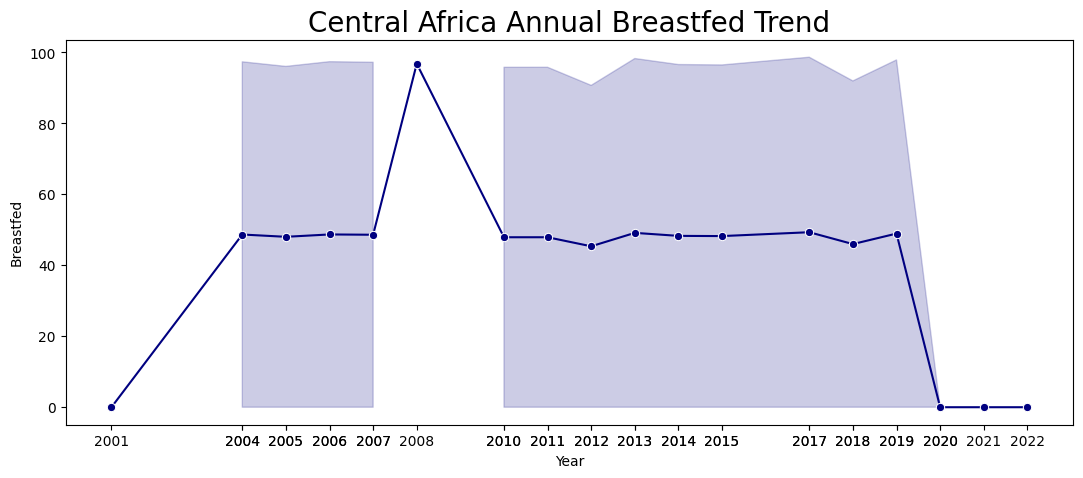

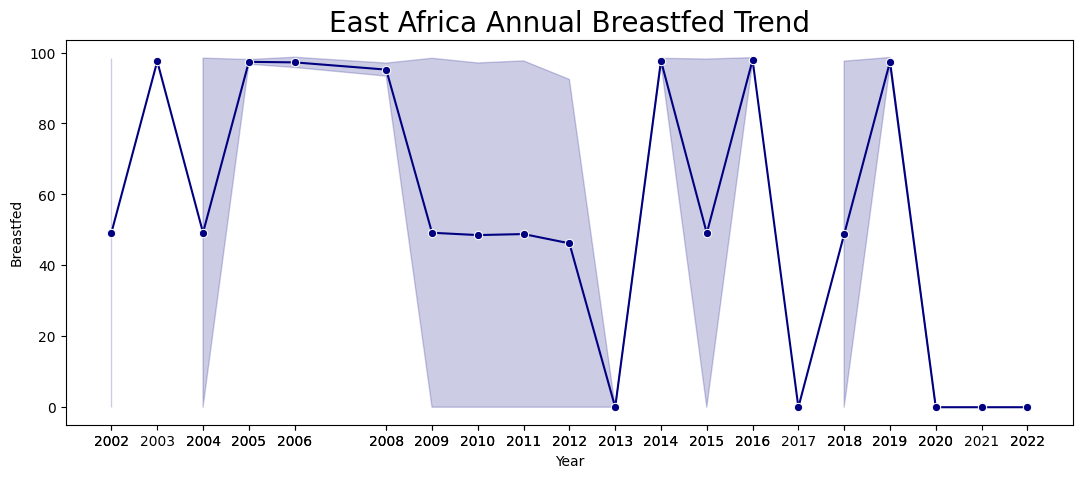

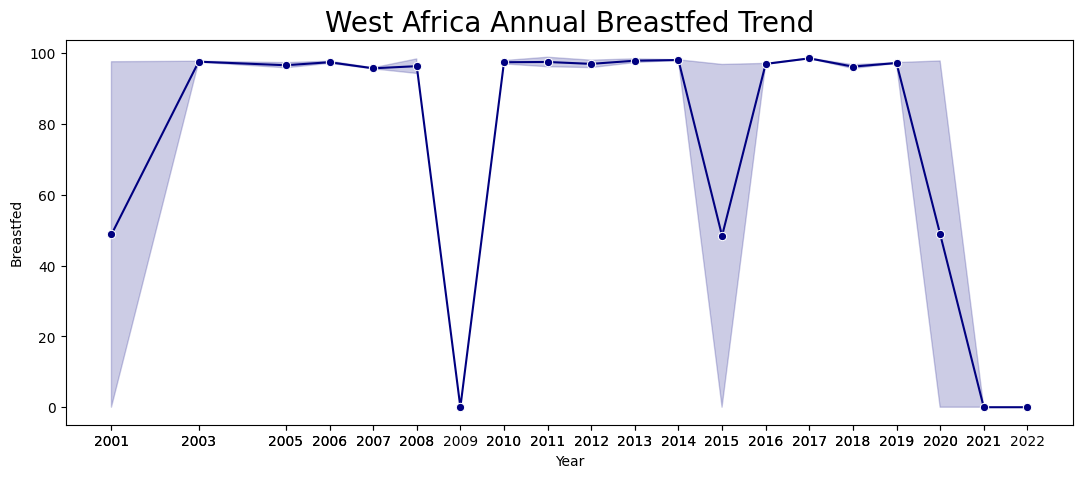

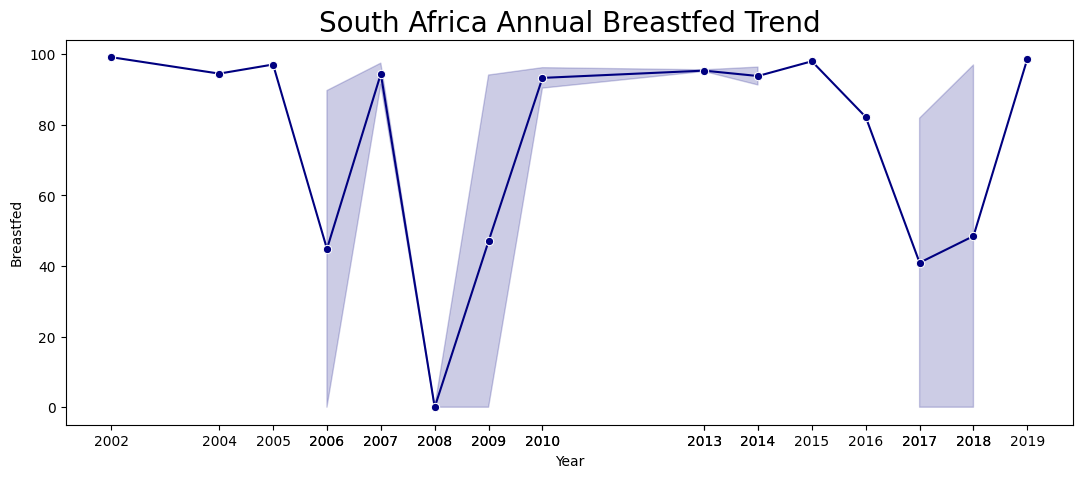

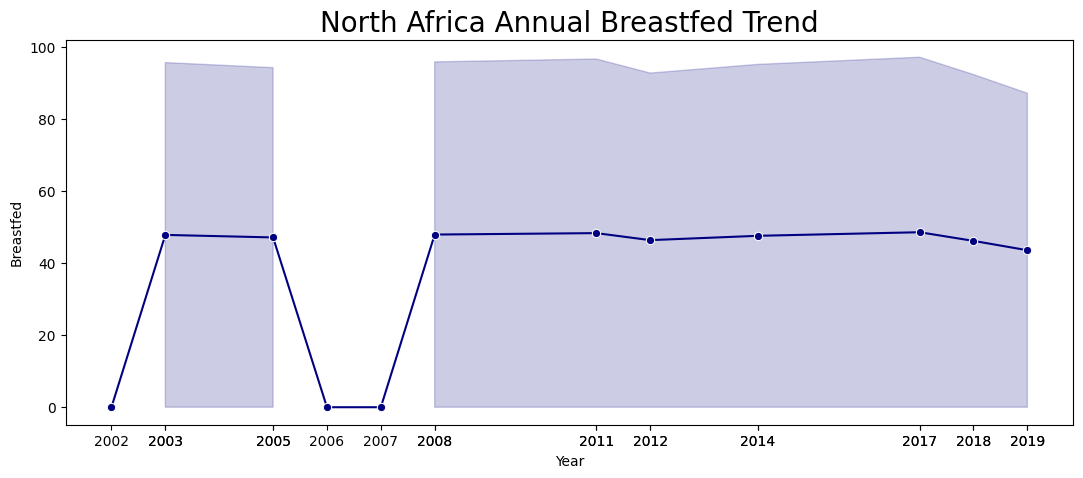

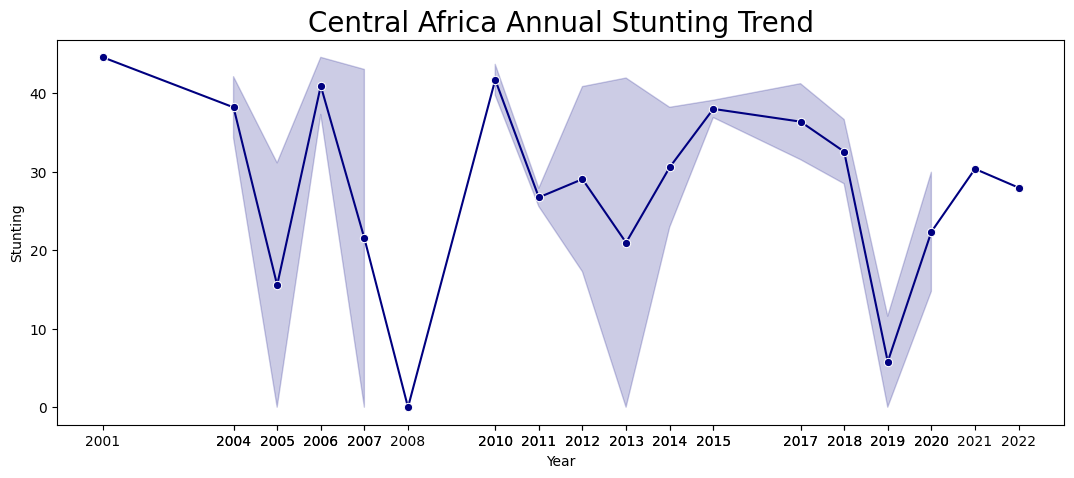

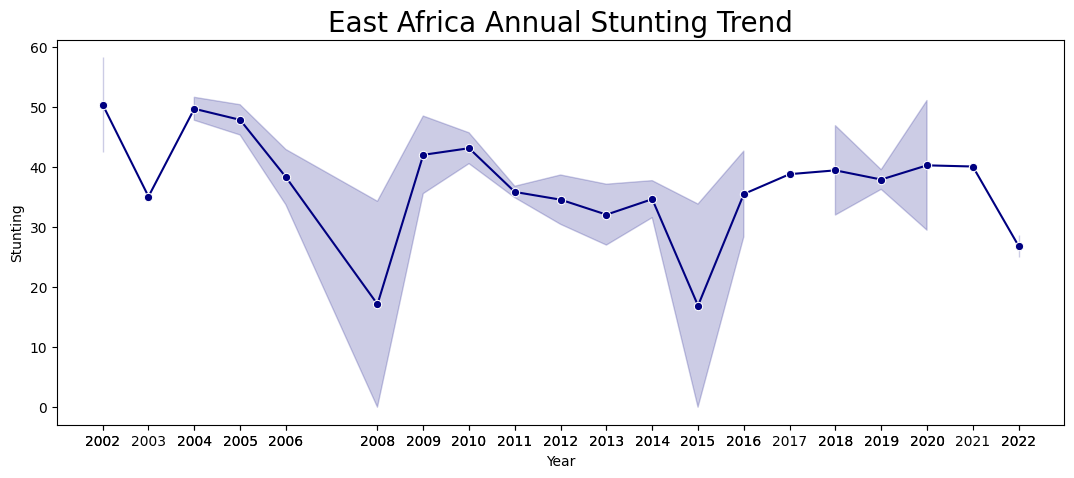

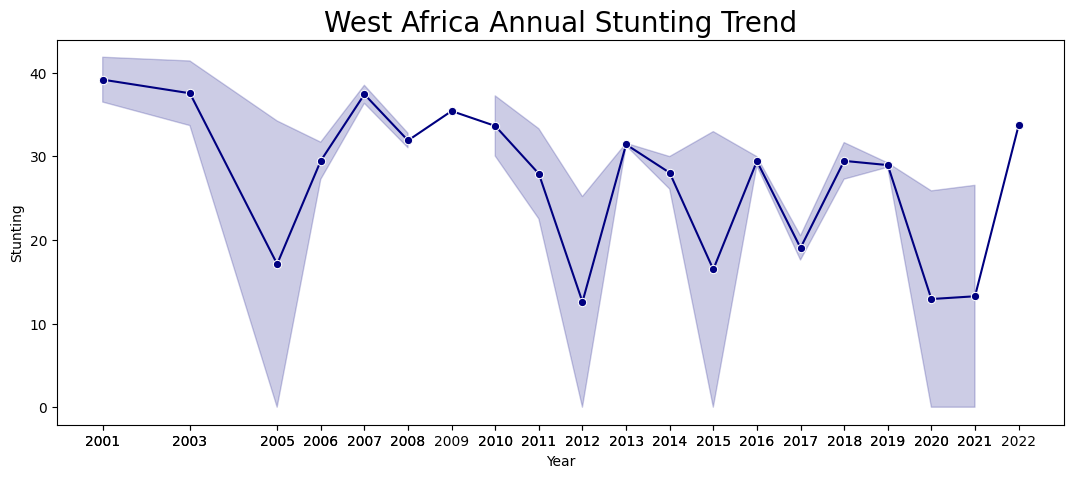

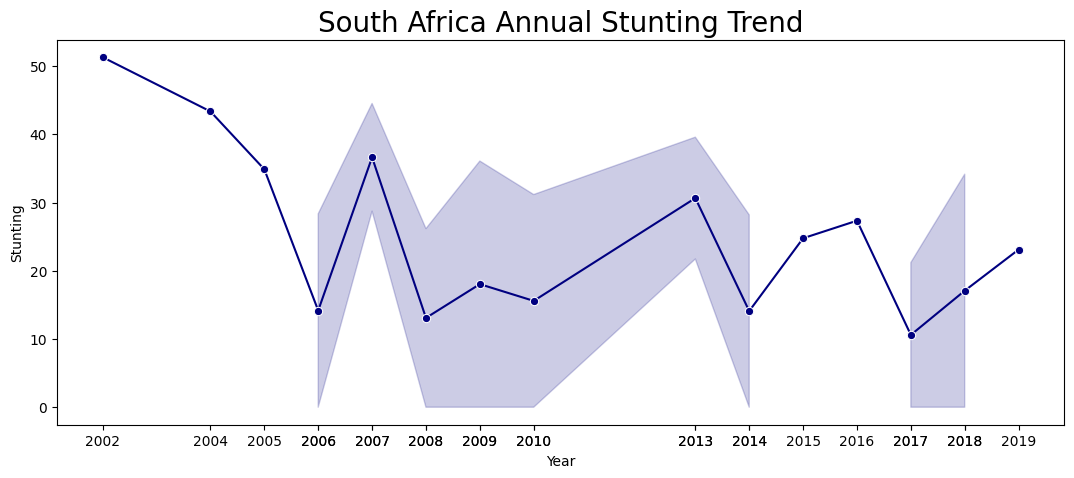

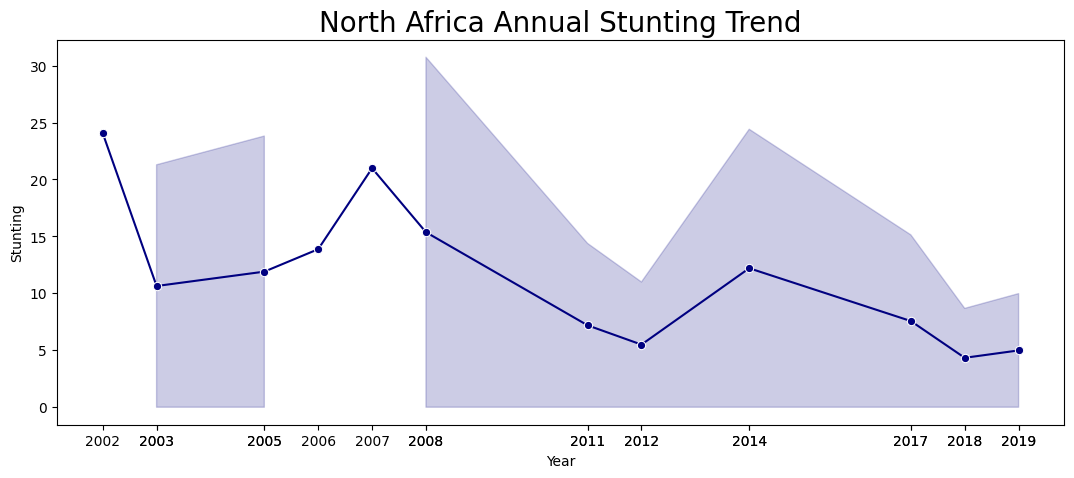

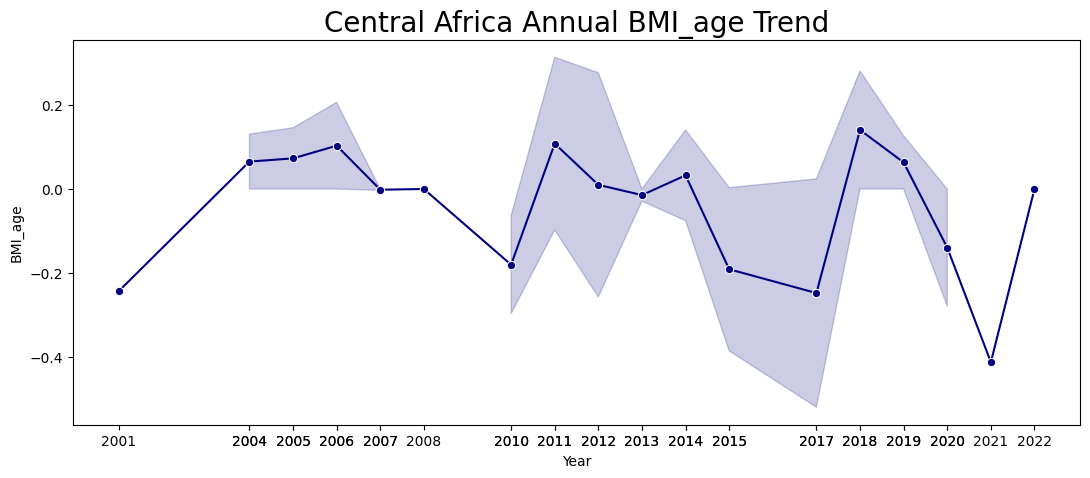

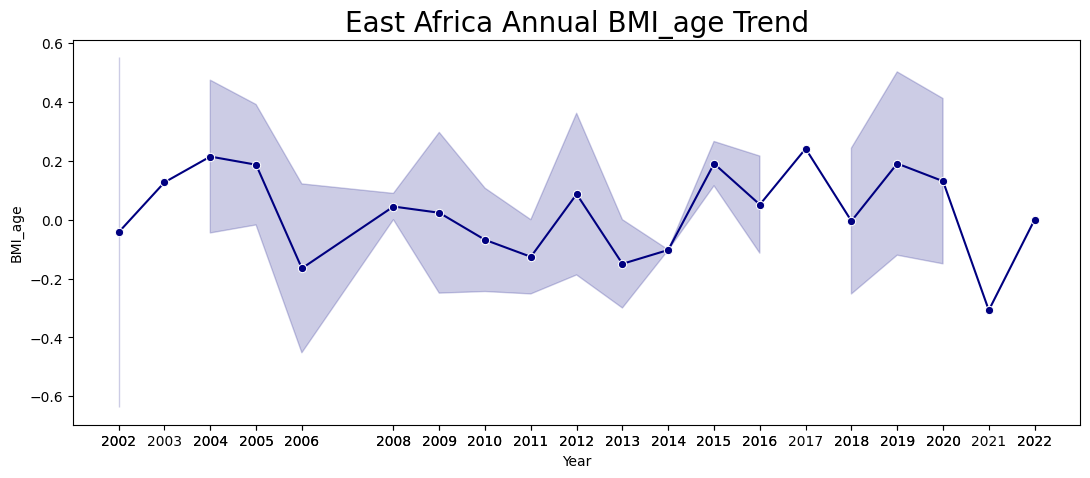

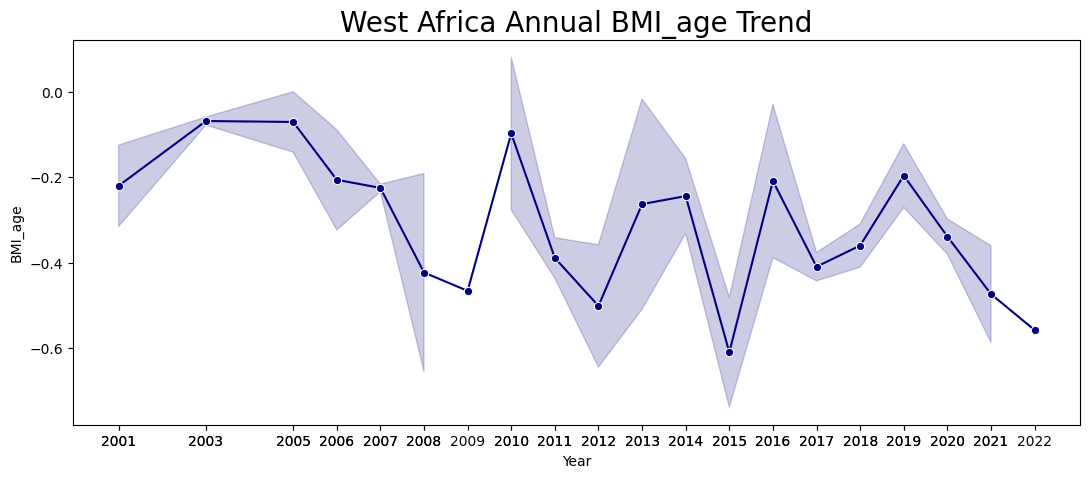

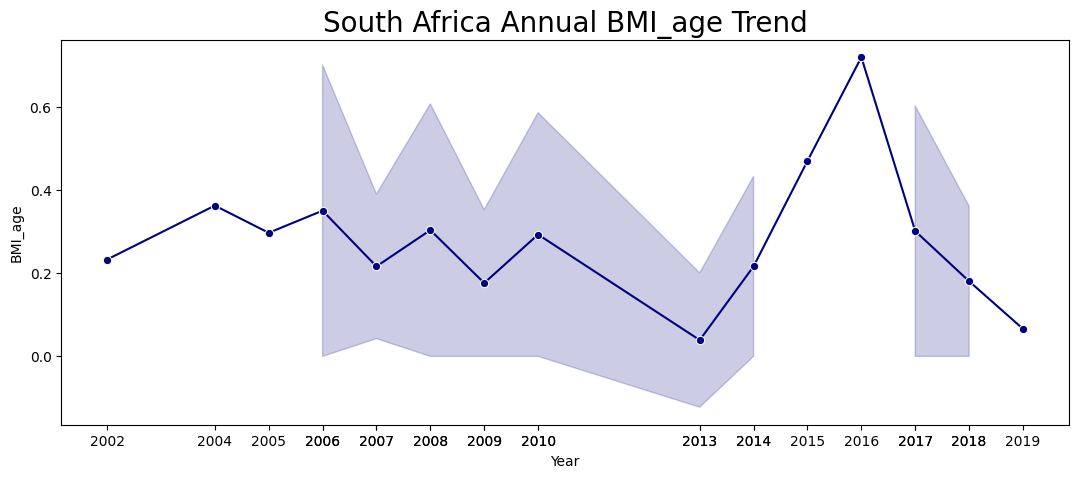

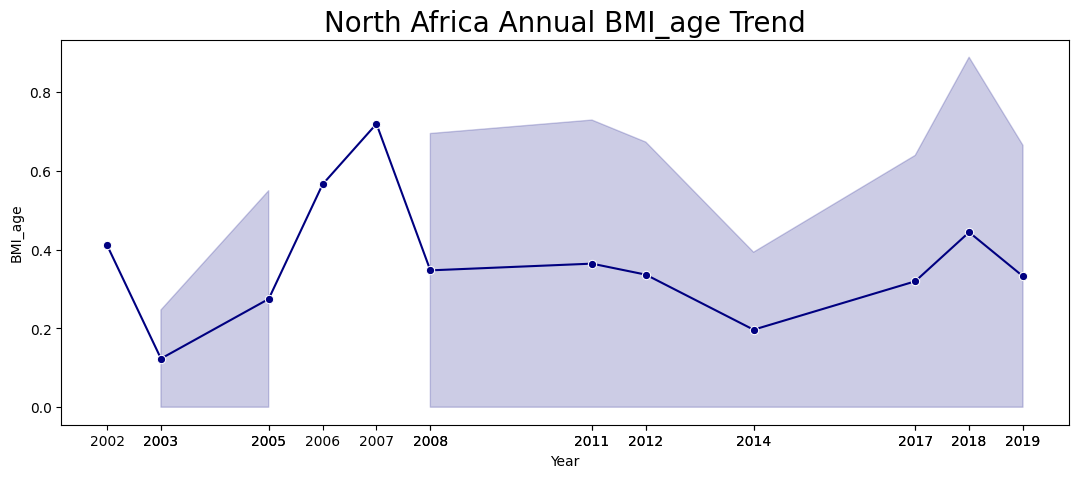

In [ ]:
for i in random.sample(mal_list, 3):
  for j in region_list:
    plt_trend(j,i)

SARIMA Timeseries

In [ ]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

def time_series_sarima(x):
  temp_pivot = ind_df.pivot_table(index=['Region','Year'], columns='Indicator', values='Observation_value', aggfunc=np.mean, fill_value=0)
  temp_pivot.rename(columns=ind_rename, inplace=True)
  temp_pivot.reset_index(inplace=True)

  for i in region_list:
    temp_df = temp_pivot[temp_pivot['Region'] == i]
    temp_df['Year'] = pd.to_datetime(temp_df['Year'], format='%Y')
    timeseries_df = temp_df[['Year', x]].copy()
    timeseries_df.rename(columns={'Year': 'ds', x: 'y'}, inplace=True)
    timeseries_df.set_index('ds', inplace=True)

    train_data, test_data = train_test_split(timeseries_df, test_size=0.2, random_state=42)

    # SARIMA Model
    order = (1, 1, 1)  # Example order, you may need to tune these parameters
    seasonal_order = (1, 1, 1, 12)  # Example seasonal order, adjust as needed

    sarima_model = SARIMAX(train_data['y'], order=order, seasonal_order=seasonal_order)
    sarima_results = sarima_model.fit(disp=False)

    predictions = sarima_results.get_forecast(steps=len(test_data))
    predicted_values = predictions.predicted_mean

    # Evaluate using MAPE and RMSE
    actual_values = test_data['y'] # replace 'YourTargetColumn' with your actual target column
    mape = mean_absolute_error(actual_values, predicted_values) / actual_values.mean() * 100
    #np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

    # Forecast next 10 years
    sarima_model = SARIMAX(timeseries_df['y'], order=order, seasonal_order=seasonal_order)
    sarima_results = sarima_model.fit(disp=False)
    forecast_steps = 10
    forecast = sarima_results.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(train_data.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='A')
    forecast_df = pd.DataFrame({'ds': forecast_index, 'y': forecast.predicted_mean})

    # Plot the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries_df.index, timeseries_df['y'], label='Observed')
    plt.plot(forecast_df['ds'], forecast_df['y'], label='Forecast', linestyle='--')
    plt.title(f"{x} for {i} - SARIMA Forecast")
    plt.xlabel('Year')
    plt.ylabel(x)
    plt.legend()
    plt.show();

    print(f'MAPE: {mape:.2f}%')
    print(f'RMSE: {rmse:.2f}')
    print("----------------------------------------------------")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

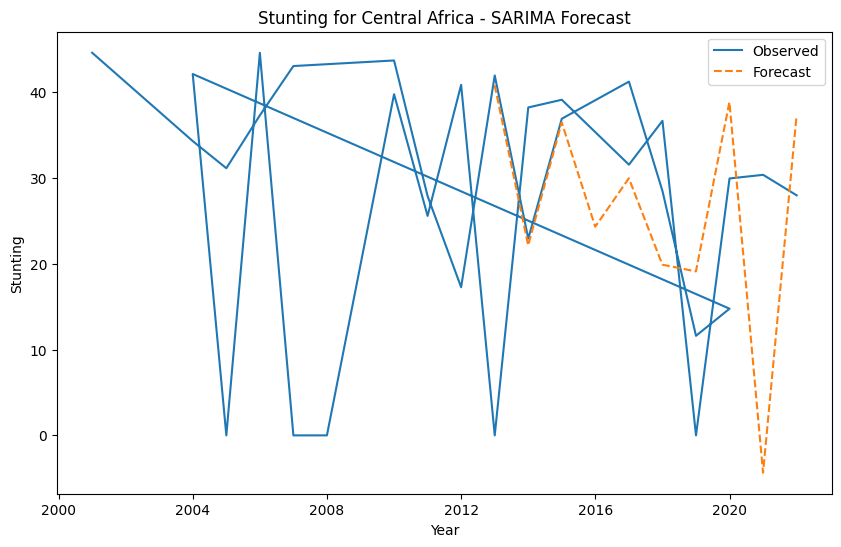

MAPE: 85.45%
RMSE: 34.17
----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

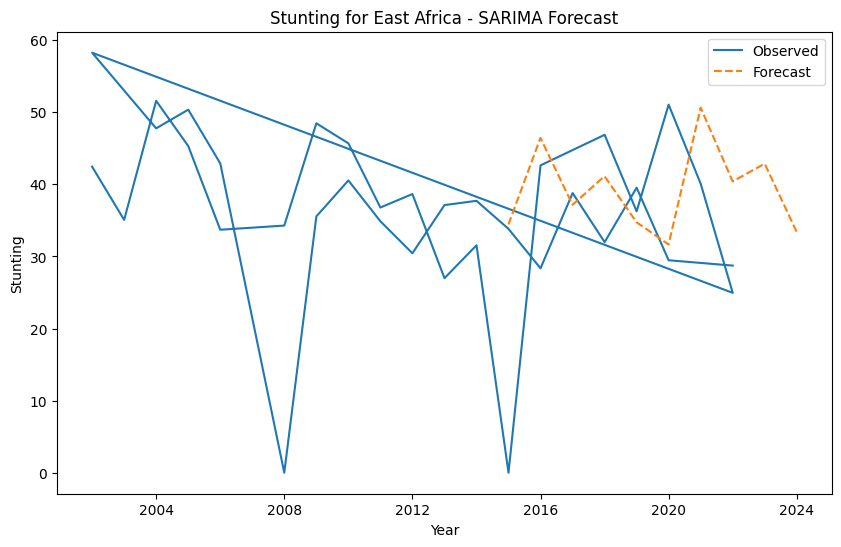

MAPE: 55.75%
RMSE: 22.89
----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

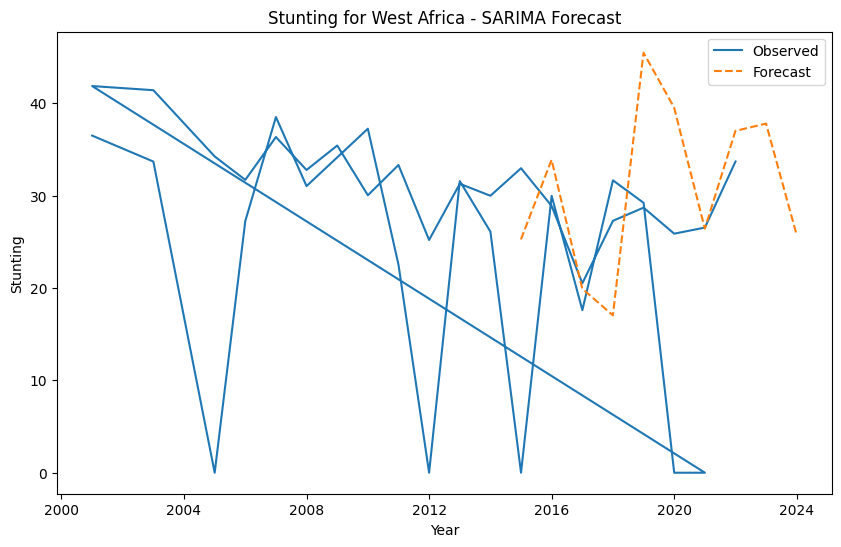

MAPE: 50.62%
RMSE: 17.12
----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

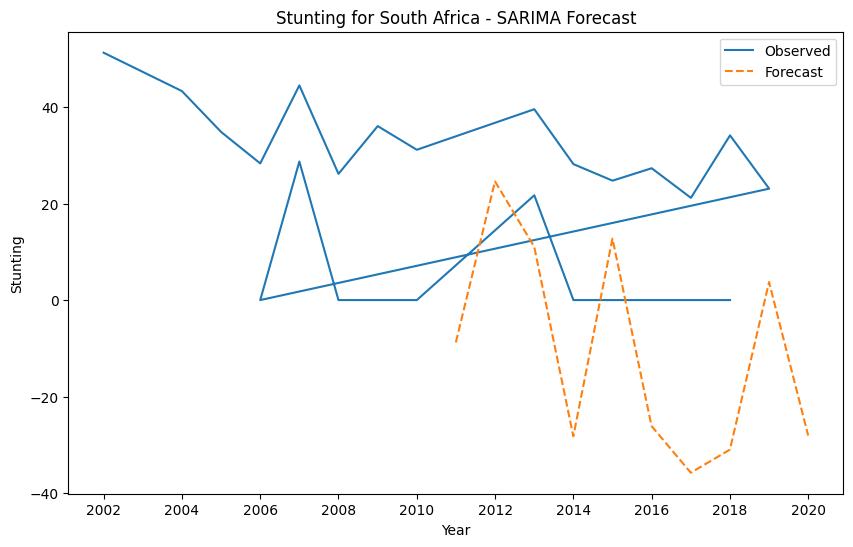

MAPE: 77.20%
RMSE: 28.04
----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

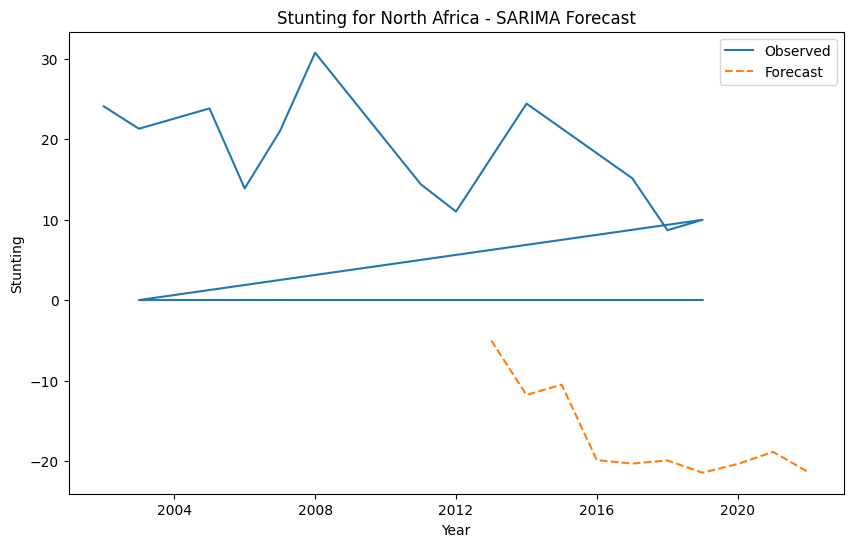

MAPE: 131.59%
RMSE: 19.46
----------------------------------------------------


In [ ]:
# Assuming you have defined ind_df, ind_rename, region_list before calling the function
# Call the function with the desired variable
time_series_sarima('Stunting')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

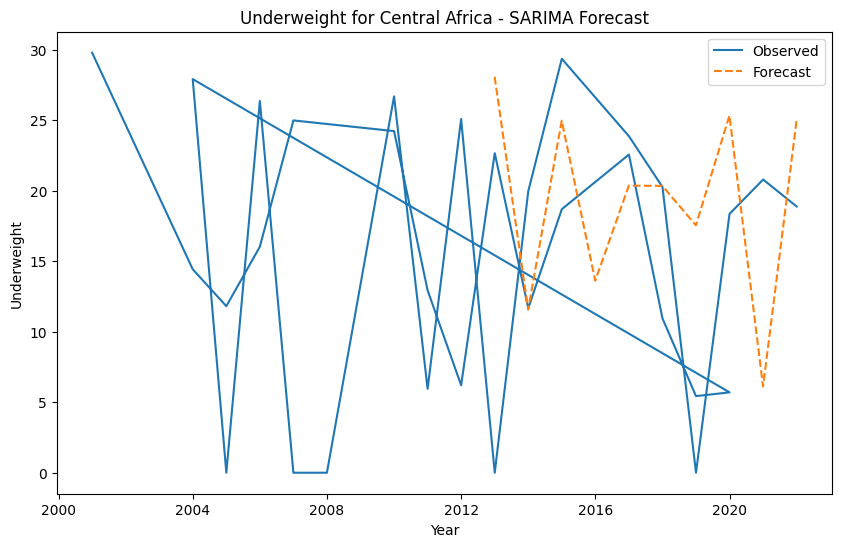

MAPE: 98.56%
RMSE: 23.06
----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

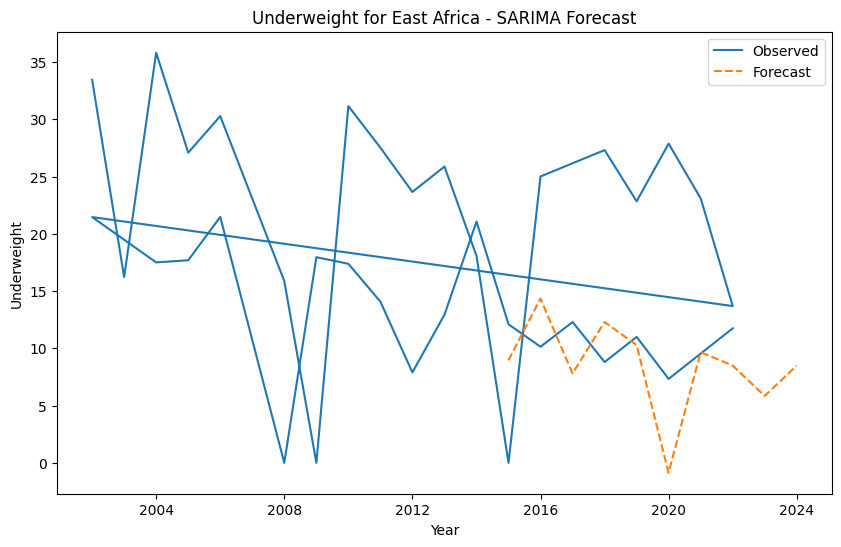

MAPE: 36.54%
RMSE: 8.62
----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

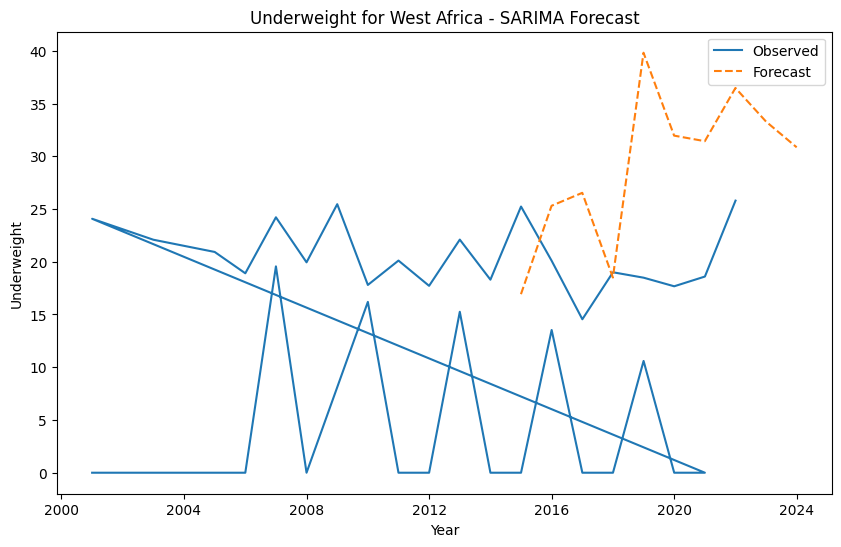

MAPE: 34.39%
RMSE: 7.58
----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

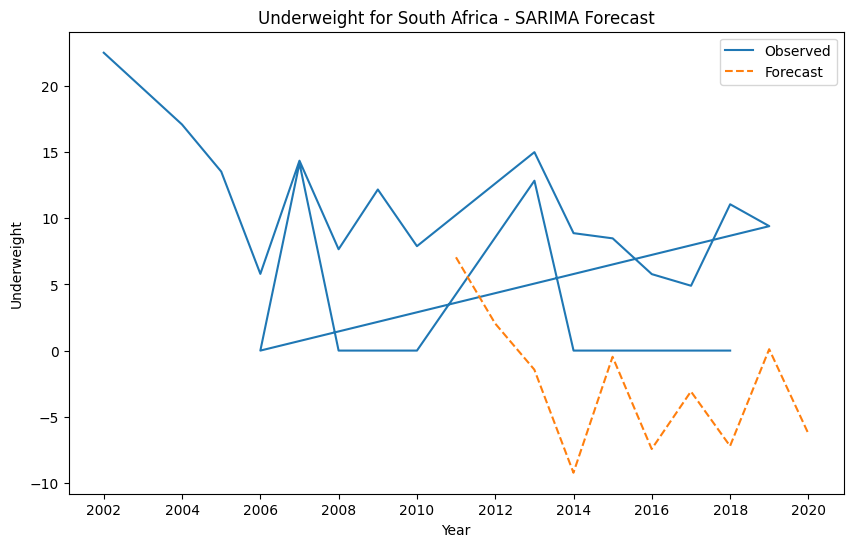

MAPE: 85.77%
RMSE: 11.39
----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

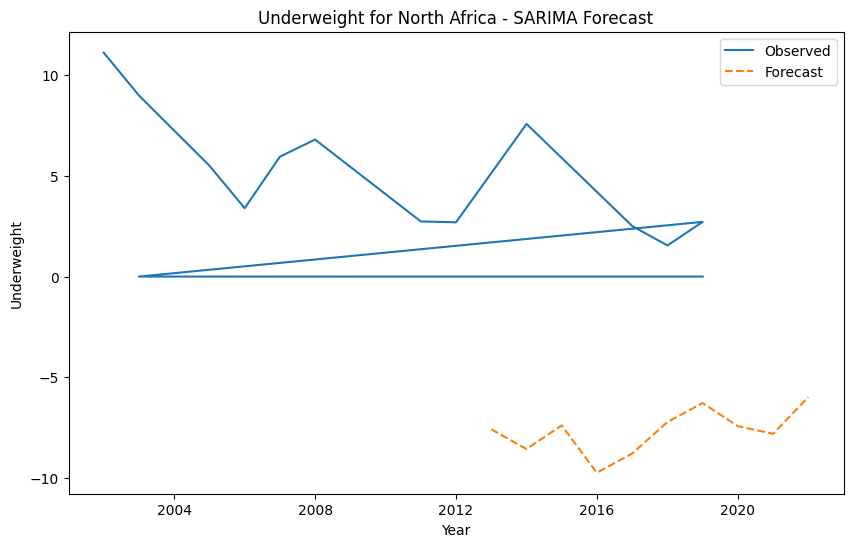

MAPE: 109.22%
RMSE: 6.65
----------------------------------------------------


In [ ]:
time_series_sarima('Underweight')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

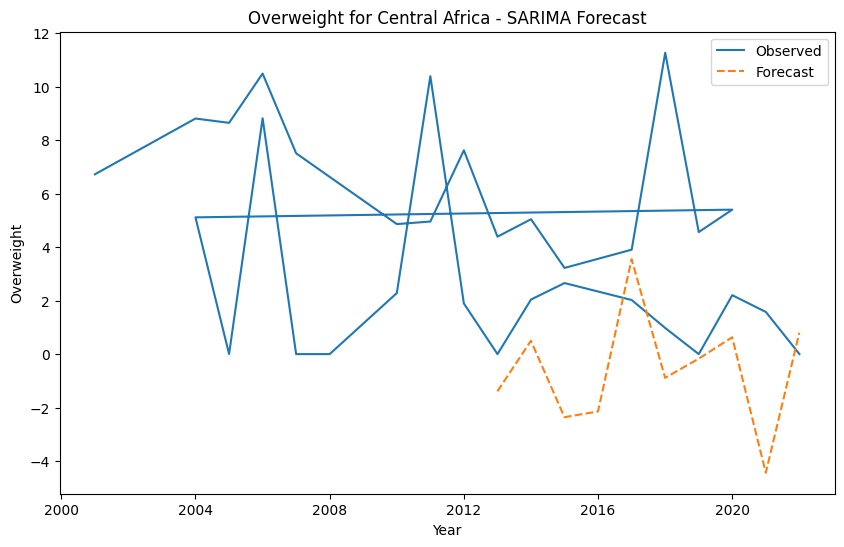

MAPE: 99.42%
RMSE: 5.14
----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

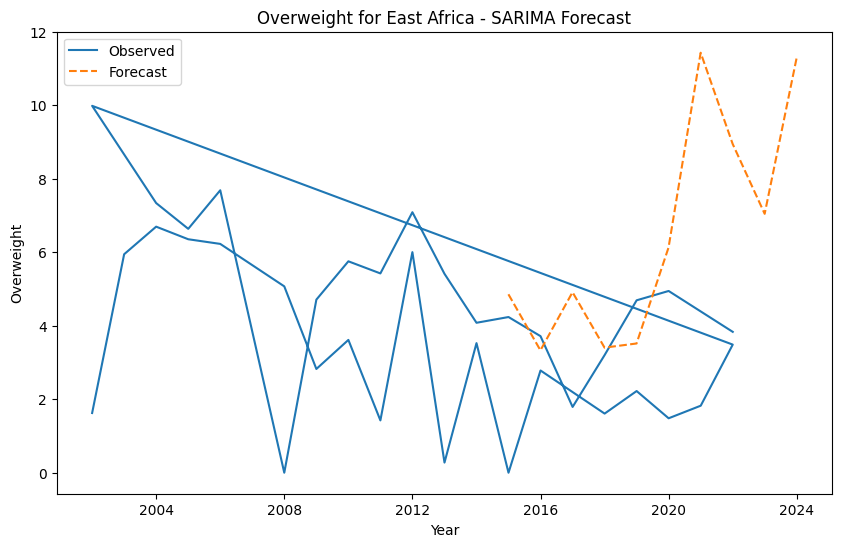

MAPE: 95.64%
RMSE: 4.62
----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

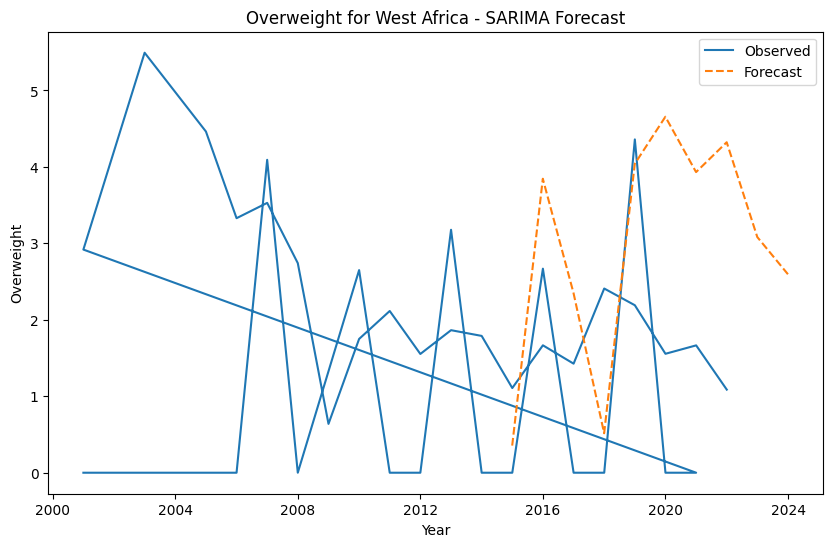

MAPE: 52.16%
RMSE: 1.25
----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

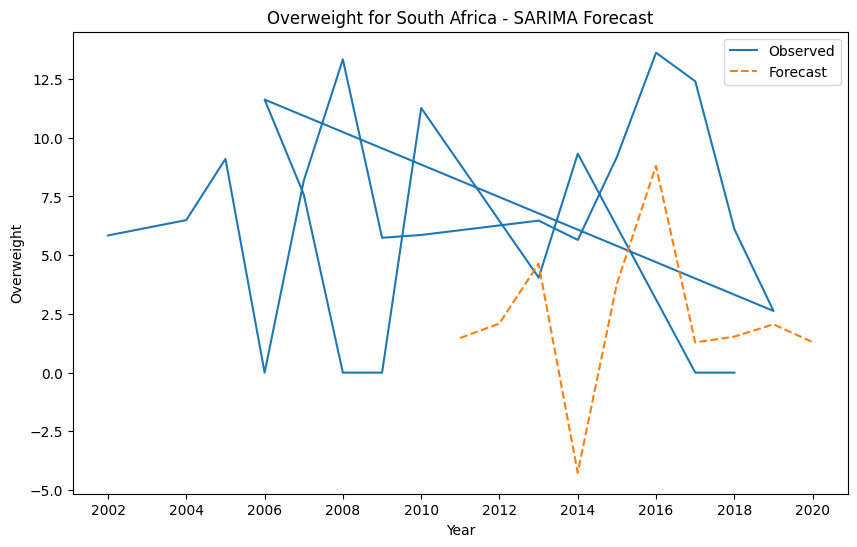

MAPE: 111.10%
RMSE: 9.37
----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

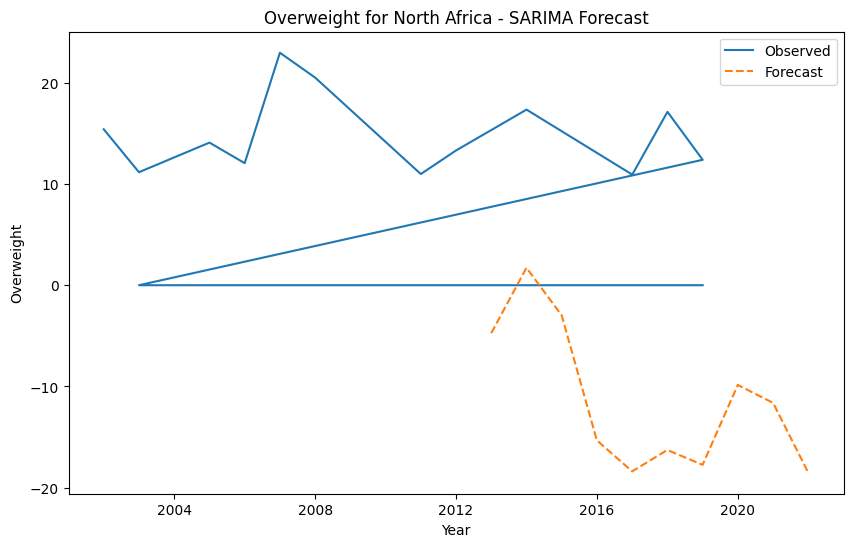

MAPE: 171.59%
RMSE: 18.73
----------------------------------------------------


In [ ]:
time_series_sarima('Overweight')

Facebook Prophet Timeseries

In [ ]:
def time_series(x):
  temp_pivot = ind_df.pivot_table(index=['Region','Year'], columns='Indicator',values='Observation_value',aggfunc=np.mean,fill_value=0)
  temp_pivot.rename(columns = ind_rename, inplace = True)
  temp_pivot.reset_index(inplace=True)
  logging.getLogger("cmdstanpy").disabled = True

  for i in region_list:
    temp_df = temp_pivot[temp_pivot['Region']==i]
    temp_df['Year'] = pd.to_datetime(temp_df['Year'], format='%Y')
    timeseries_df=temp_df[['Year', x]].copy()
    timeseries_df.rename(columns = {'Year':'ds', x:'y'}, inplace = True)

    train_data, test_data = train_test_split(timeseries_df, test_size=0.2, random_state=42)

    fb1=Prophet()
    fb1.fit(train_data)

    future = fb1.make_future_dataframe(periods=len(test_data))
    forecast = fb1.predict(future)

    # Extracting predicted values
    predicted_values = forecast[-len(test_data):]['yhat']

    # Evaluate using MAPE and RMSE
    actual_values = test_data['y'] # replace 'YourTargetColumn' with your actual target column
    mape = mean_absolute_error(actual_values, predicted_values) / actual_values.mean() * 100
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

    fb1=Prophet()
    fb1.fit(timeseries_df)

    # Predicting next 10 years
    future_dates=fb1.make_future_dataframe(10, freq='A')
    prediction=fb1.predict(future_dates)

    # plot the predicted projection
    fb1.plot(prediction,include_legend=True)
    plt.title( "FB " + x + " for " + i)

    print("----------------------------------------------------")
    print("FB " + x + " for " + i)
    print(f'MAPE: {mape:.2f}%')
    print(f'RMSE: {rmse:.2f}')
    print("----------------------------------------------------")



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.


----------------------------------------------------
FB Stunting for Central Africa
MAPE: 14.42%
RMSE: 5.84
----------------------------------------------------


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.


----------------------------------------------------
FB Stunting for East Africa
MAPE: 49.82%
RMSE: 22.23
----------------------------------------------------


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 14.


----------------------------------------------------
FB Stunting for West Africa
MAPE: 153.25%
RMSE: 55.08
----------------------------------------------------


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.


----------------------------------------------------
FB Stunting for South Africa
MAPE: 79.80%
RMSE: 26.24
----------------------------------------------------


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


----------------------------------------------------
FB Stunting for North Africa
MAPE: 93.60%
RMSE: 14.66
----------------------------------------------------


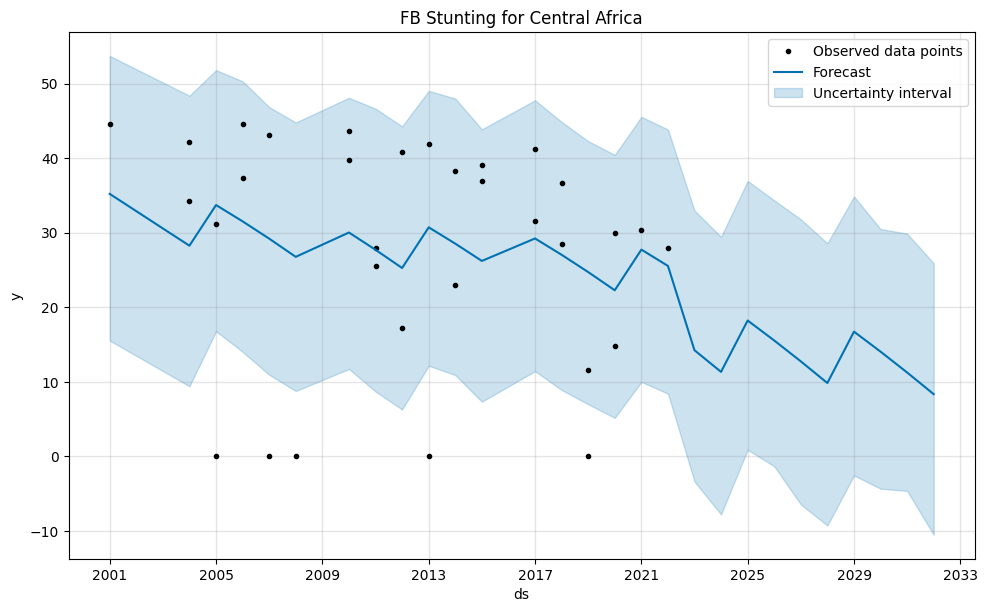

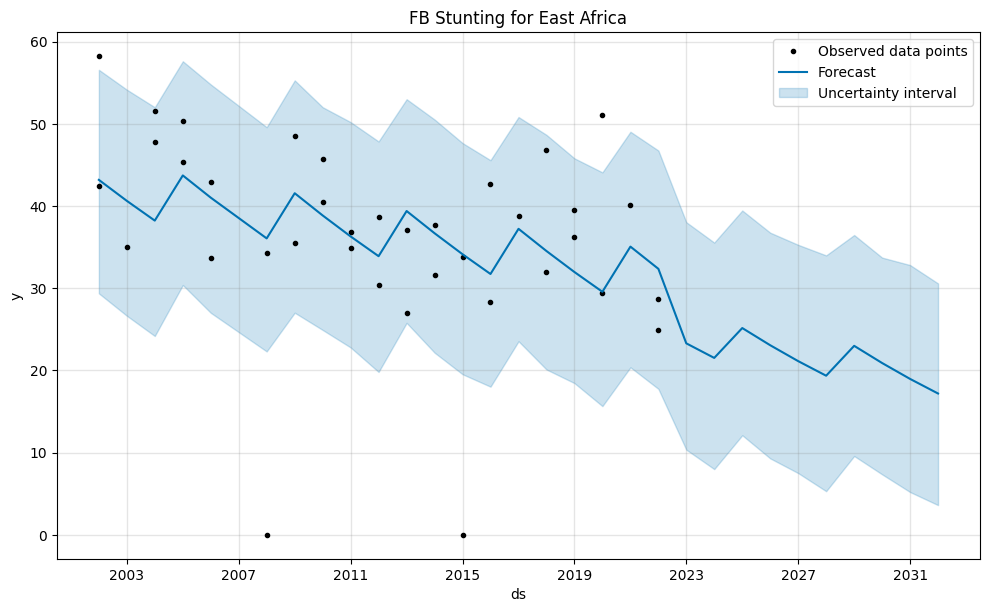

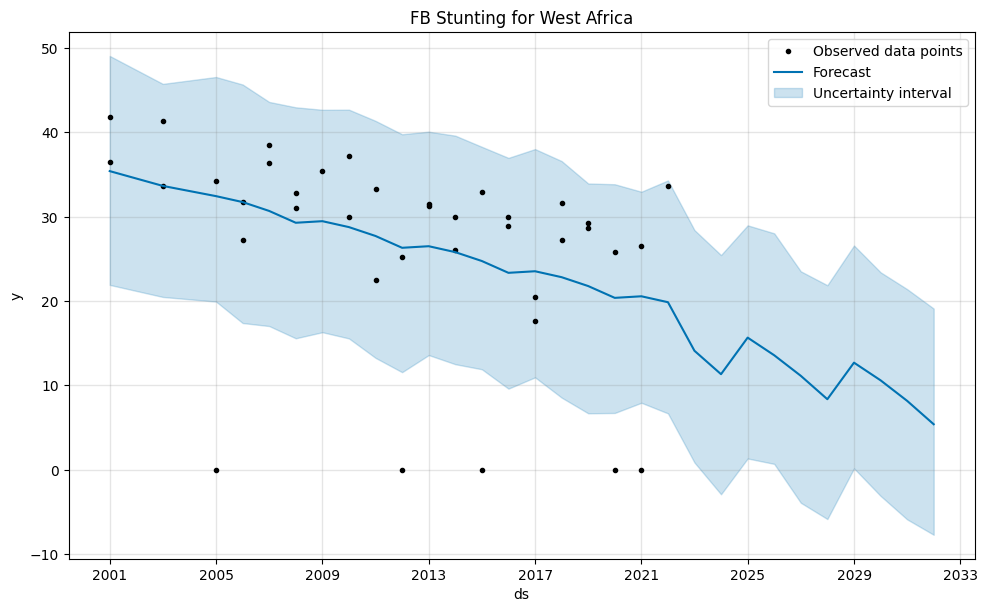

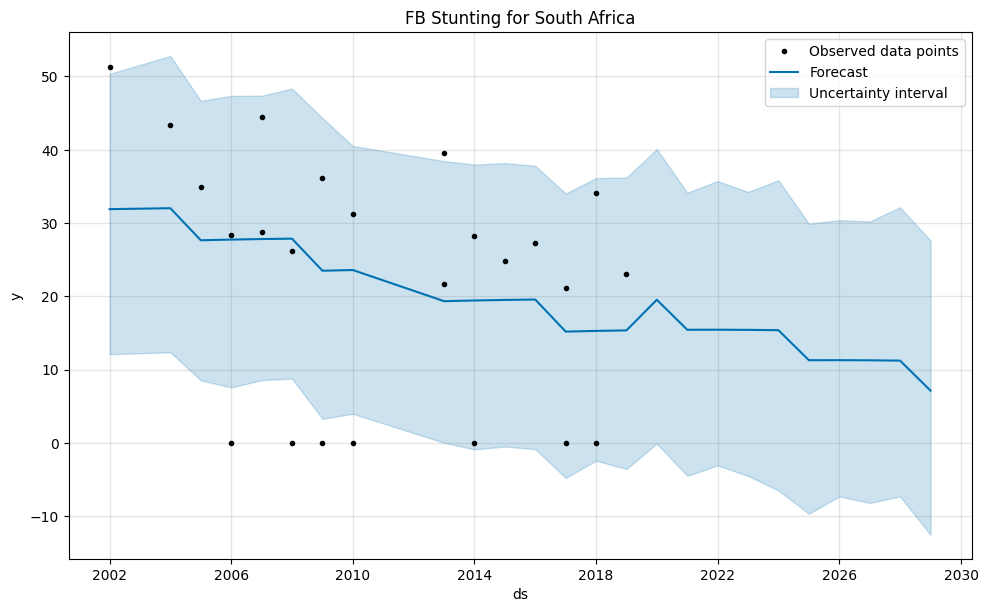

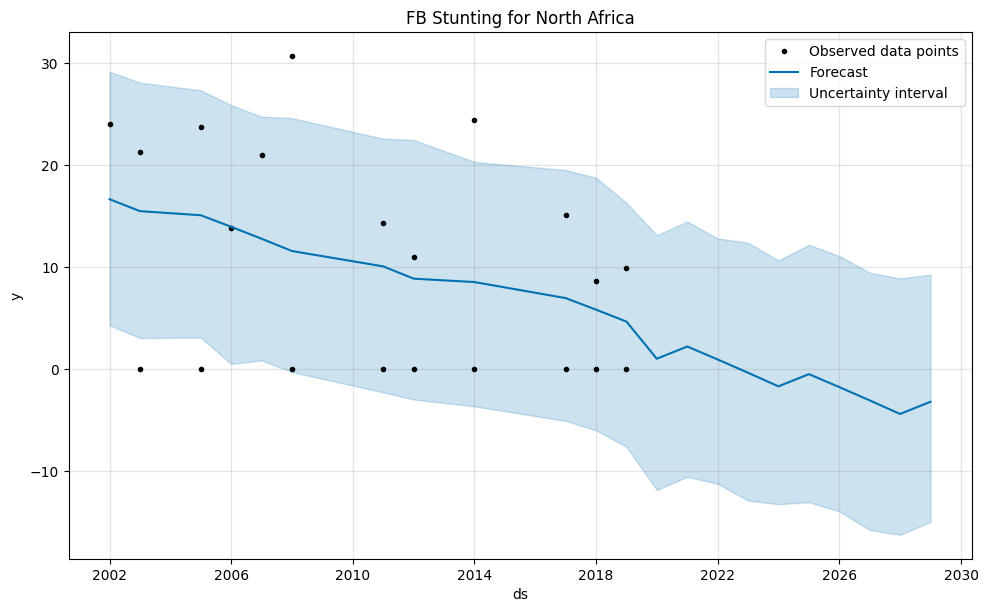

In [ ]:
time_series('Stunting')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.


----------------------------------------------------
FB Underweight for Central Africa
MAPE: 43.83%
RMSE: 11.13
----------------------------------------------------


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.


----------------------------------------------------
FB Underweight for East Africa
MAPE: 37.38%
RMSE: 7.71
----------------------------------------------------


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 14.


----------------------------------------------------
FB Underweight for West Africa
MAPE: 85.59%
RMSE: 17.91
----------------------------------------------------


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.


----------------------------------------------------
FB Underweight for South Africa
MAPE: 78.28%
RMSE: 10.39
----------------------------------------------------


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


----------------------------------------------------
FB Underweight for North Africa
MAPE: 107.66%
RMSE: 7.56
----------------------------------------------------


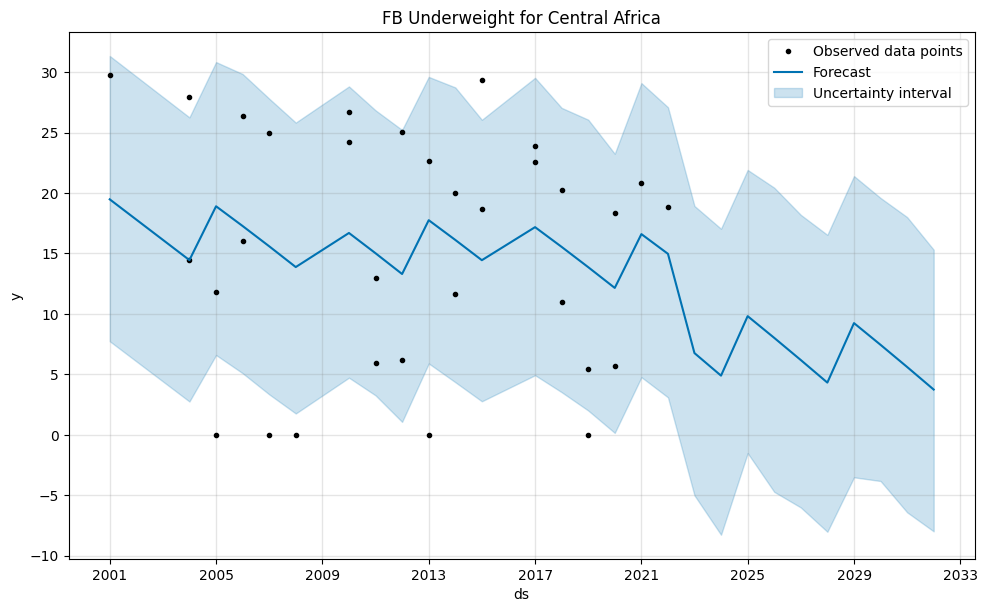

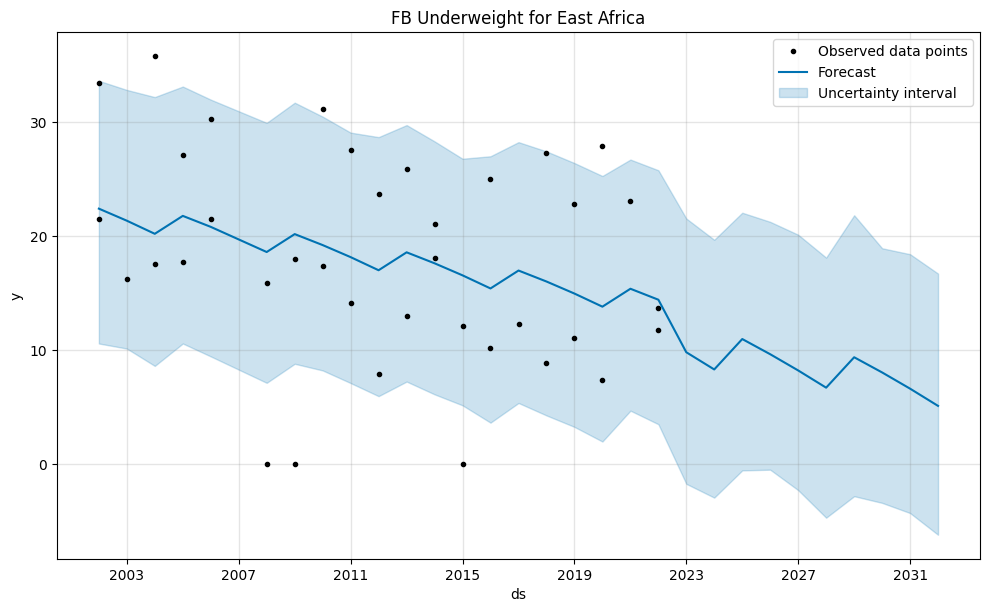

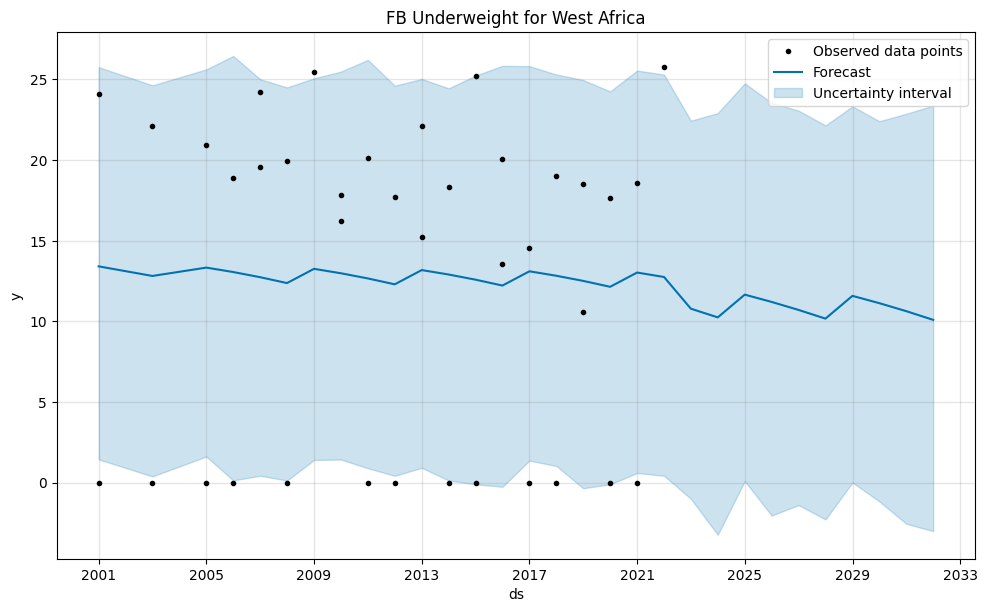

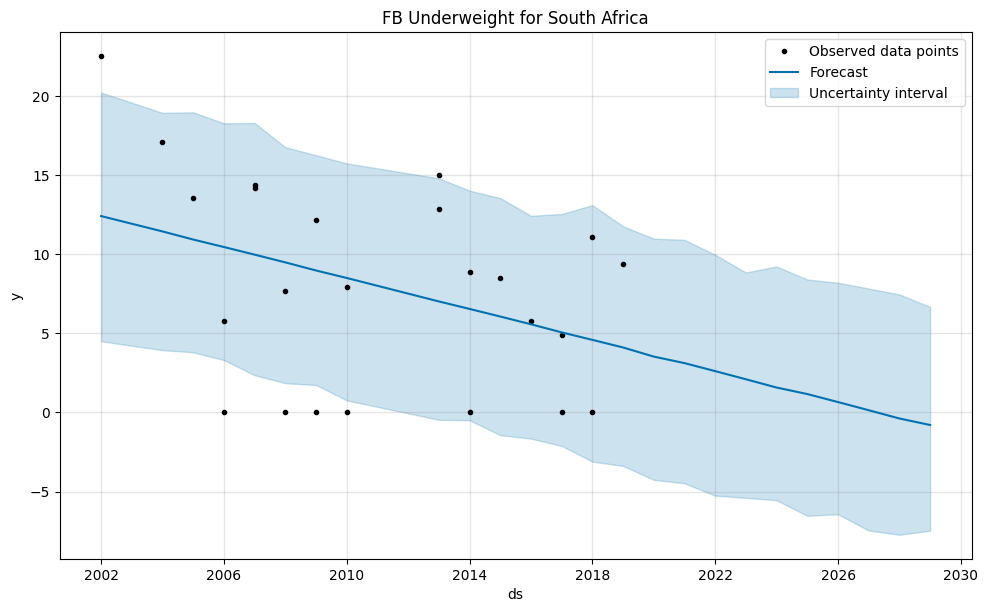

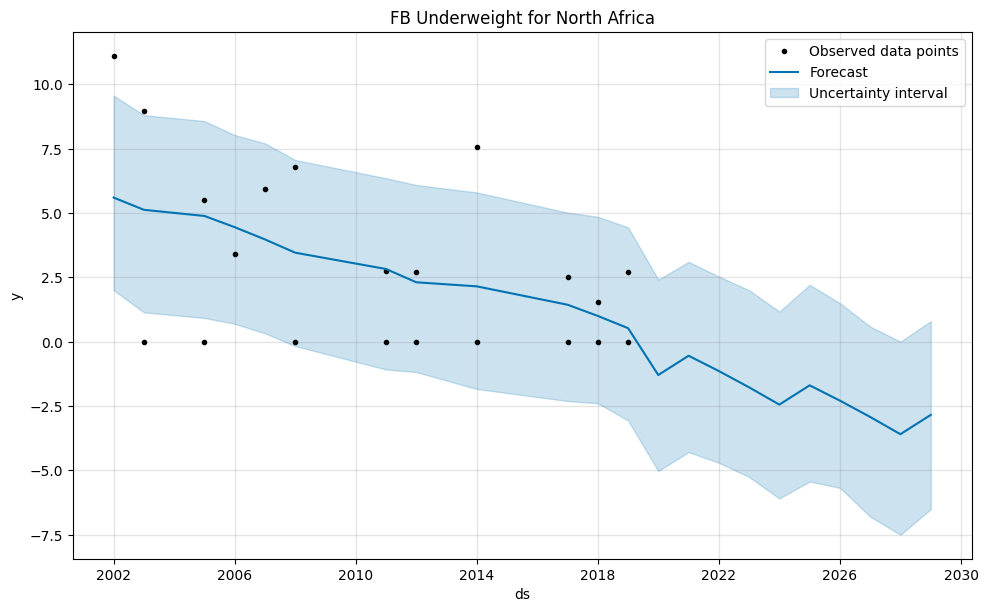

In [ ]:
time_series('Underweight')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.


----------------------------------------------------
FB Overweight for Central Africa
MAPE: 267.37%
RMSE: 12.61
----------------------------------------------------


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.


----------------------------------------------------
FB Overweight for East Africa
MAPE: 68.65%
RMSE: 3.34
----------------------------------------------------


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 14.


----------------------------------------------------
FB Overweight for West Africa
MAPE: 183.93%
RMSE: 4.11
----------------------------------------------------


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.


----------------------------------------------------
FB Overweight for South Africa
MAPE: 54.10%
RMSE: 4.76
----------------------------------------------------


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


----------------------------------------------------
FB Overweight for North Africa
MAPE: 132.71%
RMSE: 15.15
----------------------------------------------------


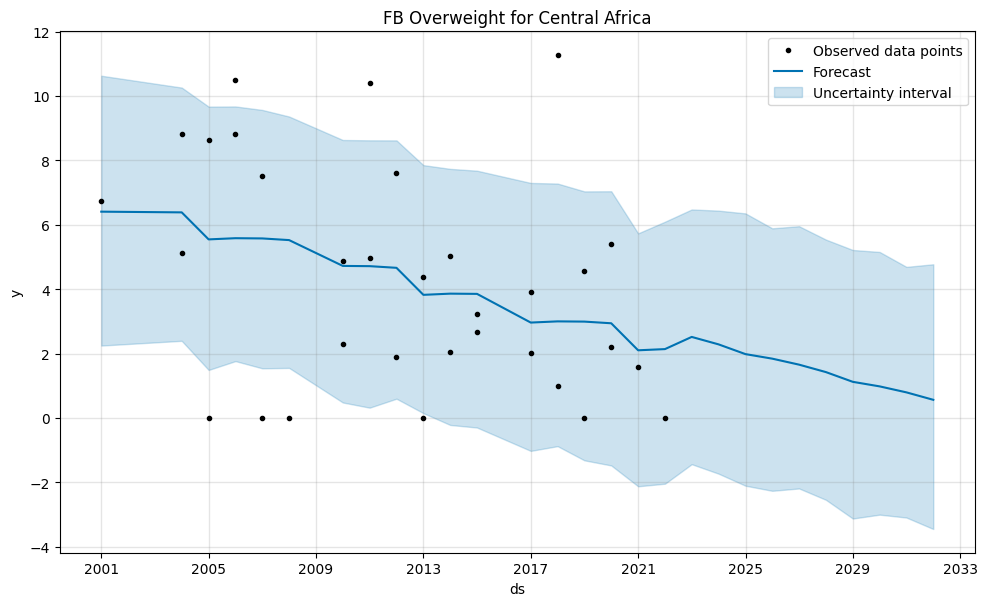

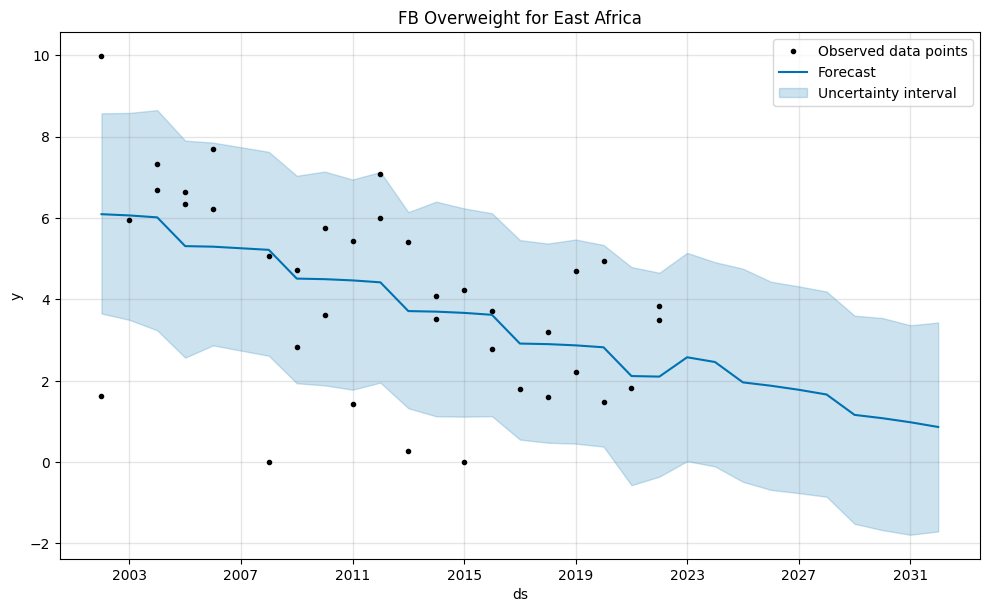

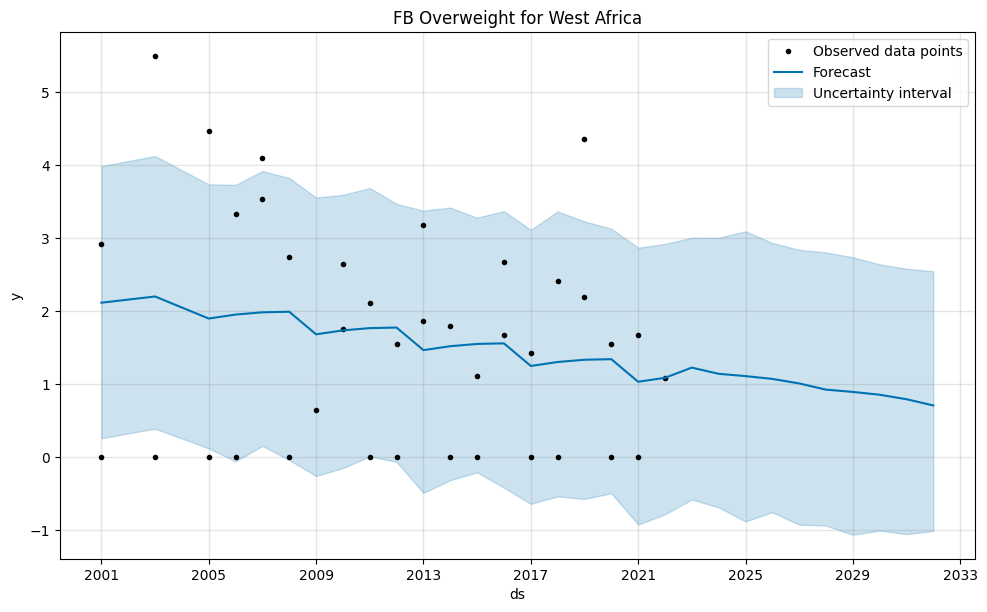

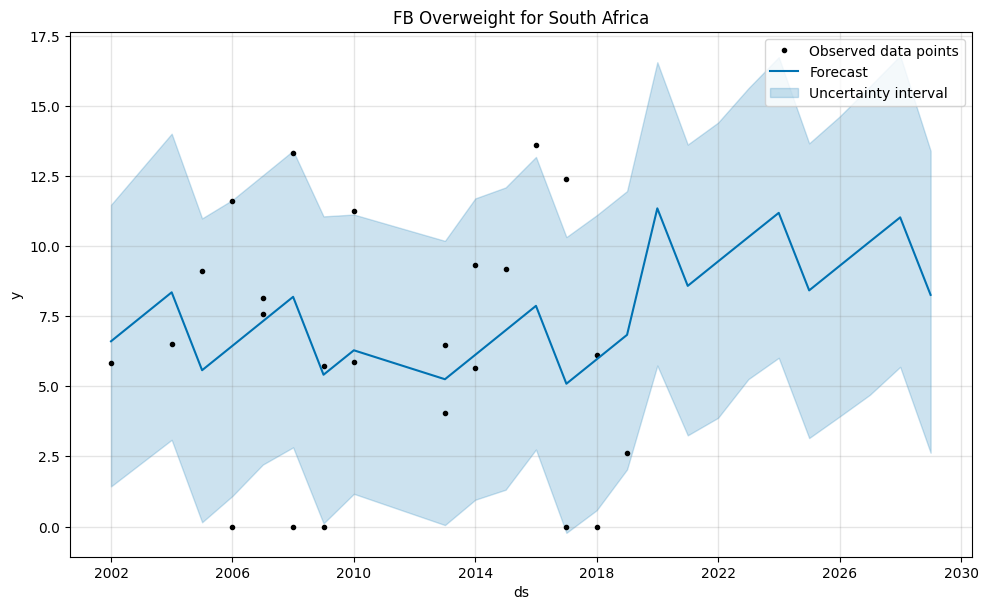

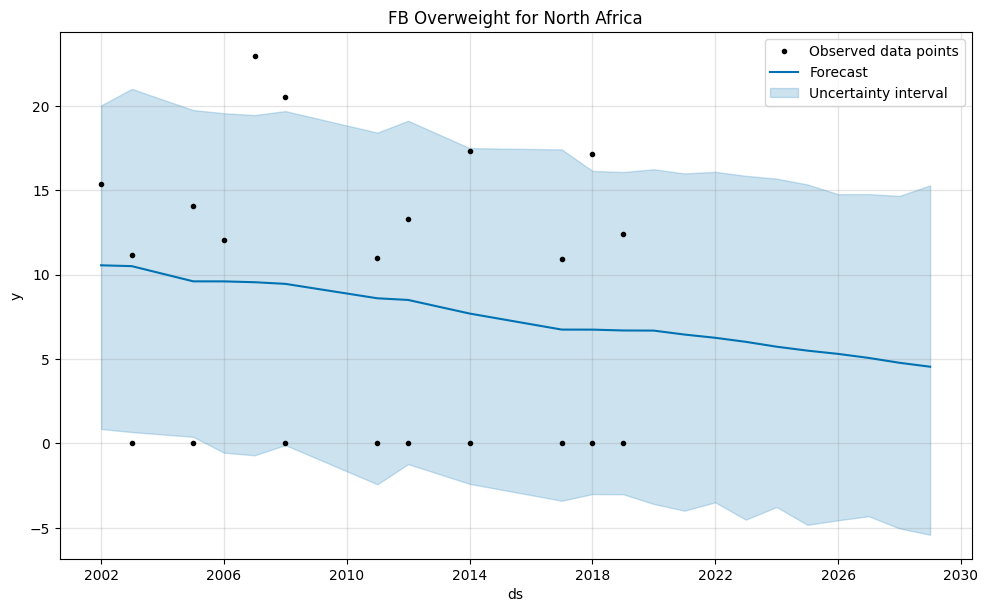

In [ ]:
time_series('Overweight')